In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd


from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import rand 
from sklearn.metrics import classification_report
from time import time
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row

In [8]:

sc =SparkContext()
print (sc.version)



3.0.1


In [9]:
rdd1 = sc.textFile("amazon_cells_labelled.txt")
rdd1.take(5)

['So there is no way for me to plug it in here in the US unless I go by a converter.\t0',
 'Good case, Excellent value.\t1',
 'Great for the jawbone.\t1',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!\t0',
 'The mic is great.\t1']

In [10]:
# Split a review sentence and a corresponding label 
rdd2 = rdd1.map(lambda x: x.split("\t"))
rdd2.take(5)

[['So there is no way for me to plug it in here in the US unless I go by a converter.',
  '0'],
 ['Good case, Excellent value.', '1'],
 ['Great for the jawbone.', '1'],
 ['Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!',
  '0'],
 ['The mic is great.', '1']]

In [11]:
# Create a RDD of Rows with the field names : label and review
rdd3 = rdd2.map(lambda x: Row(review=x[0],label=x[1]))
rdd3.take(5)

[Row(review='So there is no way for me to plug it in here in the US unless I go by a converter.', label='0'),
 Row(review='Good case, Excellent value.', label='1'),
 Row(review='Great for the jawbone.', label='1'),
 Row(review='Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!', label='0'),
 Row(review='The mic is great.', label='1')]

In [20]:
sqlContext = SQLContext(sc)
# Converting an RDD to DataFrame
df=sqlContext.createDataFrame(rdd3)
# Registers this DataFrame as a temporary table using the given name
df.registerTempTable("df")
# convert String labels to Double type
df = df.withColumn("label", df.label.cast(DoubleType()))
df.show()

+--------------------+-----+
|              review|label|
+--------------------+-----+
|So there is no wa...|  0.0|
|Good case, Excell...|  1.0|
|Great for the jaw...|  1.0|
|Tied to charger f...|  0.0|
|   The mic is great.|  1.0|
|I have to jiggle ...|  0.0|
|If you have sever...|  0.0|
|If you are Razr o...|  1.0|
|Needless to say, ...|  0.0|
|What a waste of m...|  0.0|
|And the sound qua...|  1.0|
|He was very impre...|  1.0|
|If the two were s...|  0.0|
|Very good quality...|  1.0|
|The design is ver...|  0.0|
|Highly recommend ...|  1.0|
|I advise EVERYONE...|  0.0|
|    So Far So Good!.|  1.0|
|       Works great!.|  1.0|
|It clicks into pl...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [21]:
# convert the distinct labels in the input dataset to index values
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df)
# tokenizer 
tokenizer = RegexTokenizer(inputCol="review", outputCol="words", pattern="\W")##'\w' remove none-word letters
df_tokenized = tokenizer.transform(df)
# remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_removed = remover.transform(df_tokenized)
# Convert to TF words vector
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
df_TF = hashingTF.transform(df_removed)
# Convert to TF*IDF words vector
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_TF)
df_idf = idfModel.transform(df_TF)
for features_label in df_idf.select("features", "label").take(3):
    print(features_label)

Row(features=SparseVector(262144, {51471: 4.8293, 109156: 5.8101, 113100: 4.4238, 148675: 4.9628, 235273: 5.5225, 254682: 6.2156}), label=0.0)
Row(features=SparseVector(262144, {78745: 3.5766, 113432: 2.5913, 123499: 5.117, 192310: 3.5076}), label=1.0)
Row(features=SparseVector(262144, {135499: 5.5225, 261870: 2.3238}), label=1.0)


In [23]:
# Split data aproximately into training (80%) and test (20%)
(train, test)=df.randomSplit([0.8,0.2], seed = 0)
# Cache the train and test data in-memory 
train = train.cache()
test = test.cache()
print ('Sample number in the train set : {}'.format(train.count()))
print ('Sample number in the test set : {}'.format(test.count()))
train.groupby('label').count().toPandas()

Sample number in the train set : 808
Sample number in the test set : 192


,label,count
0,0.0,422
1,1.0,386


In [25]:
def grid_search(p1,p2,p3,p4):
    lr = LogisticRegression()
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, lr])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(lr.regParam, [p2])
                 .addGrid(lr.elasticNetParam, [p3])
                 .addGrid(lr.maxIter, [p4])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]

In [27]:
score=0.0
for p1 in [45000,50000,55000]:
    for p2 in [0.09,0.10,0.11]:
        for p3 in [0.09,0.10,0.11]:
            for p4 in [9,10,11]:
                t0 = time()
                print ('(numFeatures,regParam,elasticNetParam,maxIter)=({},{},{},{})'.format(p1,p2,p3,p4))
                average_score=grid_search(p1,p2,p3,p4)
                tt = time() - t0
                print ("Classifier trained in {} seconds".format(round(tt,3)))
                if average_score > score:
                    print ('################ Best score ######################')
                    params=(p1,p2,p3,p4)
                    score=average_score
print ('Best score is {} at params ={}'.format(score, params))

(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.09,9)
average cross-validation accuracy = 0.8083603645874418
Classifier trained in 11.988 seconds
################ Best score ######################
(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.09,10)
average cross-validation accuracy = 0.8110226363927155
Classifier trained in 8.387 seconds
################ Best score ######################
(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.09,11)
average cross-validation accuracy = 0.8060339779528034
Classifier trained in 8.172 seconds
(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.1,9)
average cross-validation accuracy = 0.809247344073933
Classifier trained in 8.399 seconds
(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.09,0.1,10)
average cross-validation accuracy = 0.8118715853453029
Classifier trained in 7.478 seconds
################ Best score ######################
(numFeatures,regParam,elasticNetParam,maxIter)=(45000,0.

average cross-validation accuracy = 0.8092447185349815
Classifier trained in 8.223 seconds
(numFeatures,regParam,elasticNetParam,maxIter)=(50000,0.11,0.11,9)
average cross-validation accuracy = 0.808908833364346
Classifier trained in 8.068 seconds
(numFeatures,regParam,elasticNetParam,maxIter)=(50000,0.11,0.11,10)
average cross-validation accuracy = 0.8056954672432163
Classifier trained in 7.68 seconds
(numFeatures,regParam,elasticNetParam,maxIter)=(50000,0.11,0.11,11)
average cross-validation accuracy = 0.8016370699016028
Classifier trained in 8.728 seconds
(numFeatures,regParam,elasticNetParam,maxIter)=(55000,0.09,0.09,9)
average cross-validation accuracy = 0.8183783375401217
Classifier trained in 7.533 seconds
(numFeatures,regParam,elasticNetParam,maxIter)=(55000,0.09,0.09,10)
average cross-validation accuracy = 0.822393453269928
Classifier trained in 8.447 seconds
################ Best score ######################
(numFeatures,regParam,elasticNetParam,maxIter)=(55000,0.09,0.09,11)


In [28]:
def Data_modeling(train, test, pipeline, paramGrid):
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    
    ########  Make predictions on on the test data
    prediction = cvModel.transform(test)
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    ######## Calculate accuracy of the prediction of the test data
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy_score=evaluator.evaluate(prediction)
    # another way to calculate accuracy 
    #correct=prediction.filter(prediction['label']== prediction['prediction']).select("label","prediction")
    #accuracy_score = correct.count() / float(test.count())  
    print ('Accuracy in the test data = {}'.format(accuracy_score))
    
    ######## calculate F1 score of the prediction of the test data
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score=evaluator.evaluate(prediction)
    print ('F1 score in the test data = {}'.format(f1_score))
    # Calculate area under ROC for the prediction of the test data
    #evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
    #ROC_score=evaluator.evaluate(prediction)
    #print 'areaUnderROC in the test data = {}'.format(ROC_score)
    
    ######## Print classification_report
    prediction_and_labels=prediction.select("label","prediction")
    y_true = []
    y_pred = []
    for x in prediction_and_labels.collect():
        xx = list(x)
        try:
            tt = int(xx[1])
            pp = int(xx[0])
            y_true.append(tt)
            y_pred.append(pp)
        except:
            continue

    target_names = ['neg 0', 'pos 1']
    print (classification_report(y_true, y_pred, target_names=target_names))
    return 

In [29]:
# trained by a logistic regression 
lr = LogisticRegression()
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, lr])

# Create ParamGrid for Cross Validation 
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [50000])
             .addGrid(lr.regParam, [0.10])
             .addGrid(lr.elasticNetParam, [0.10])
             .addGrid(lr.maxIter, [10])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.8132624598037392
Accuracy in the test data = 0.8020833333333334
F1 score in the test data = 0.8036541005291005
              precision    recall  f1-score   support

       neg 0       0.83      0.72      0.77        90
       pos 1       0.78      0.87      0.82       102

    accuracy                           0.80       192
   macro avg       0.81      0.80      0.80       192
weighted avg       0.81      0.80      0.80       192



In [30]:
def grid_search(p1,p2):
    nb = NaiveBayes()
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, nb])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(nb.smoothing, [p2])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]

In [31]:
score=0.0
for p1 in [35000,40000,55000]:
    for p2 in [0.8,0.9,1.0]:
      t0 = time()
      print ('(numFeatures,smoothing)=({},{})'.format(p1,p2))
      average_score=grid_search(p1,p2)
      tt = time() - t0
      print ("Classifier trained in {} seconds".format(round(tt,3)))
      if average_score > score:
        print ('################ Best score ######################')
        params=(p1,p2)
        score=average_score
print ('Best score is {} at params ={}'.format(score, params))


(numFeatures,smoothing)=(35000,0.8)
average cross-validation accuracy = 0.7643022187708135
Classifier trained in 6.12 seconds
################ Best score ######################
(numFeatures,smoothing)=(35000,0.9)
average cross-validation accuracy = 0.7657390003800091
Classifier trained in 6.421 seconds
################ Best score ######################
(numFeatures,smoothing)=(35000,1.0)
average cross-validation accuracy = 0.7669238345032318
Classifier trained in 8.432 seconds
################ Best score ######################
(numFeatures,smoothing)=(40000,0.8)
average cross-validation accuracy = 0.768061469282544
Classifier trained in 5.296 seconds
################ Best score ######################
(numFeatures,smoothing)=(40000,0.9)
average cross-validation accuracy = 0.768061469282544
Classifier trained in 6.321 seconds
(numFeatures,smoothing)=(40000,1.0)
average cross-validation accuracy = 0.7692463034057668
Classifier trained in 5.331 seconds
################ Best score #########

In [32]:
# trained by a Naïve Bayes 
nb = NaiveBayes()
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, nb])
# Create ParamGrid for Cross Validation 
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [40000])
             .addGrid(nb.smoothing, [1.0])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.7692463034057668
Accuracy in the test data = 0.7864583333333334
F1 score in the test data = 0.7866680462414771
              precision    recall  f1-score   support

       neg 0       0.74      0.73      0.74        79
       pos 1       0.82      0.82      0.82       113

    accuracy                           0.79       192
   macro avg       0.78      0.78      0.78       192
weighted avg       0.79      0.79      0.79       192



In [34]:
def grid_search(p1,p2,p3):
    # trained by a Decision Tree 
    dt = DecisionTreeClassifier(labelCol="indexedLabel",impurity="entropy")
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, dt])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(dt.maxDepth, [p2])
                 .addGrid(dt.minInstancesPerNode, [p3])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]

In [35]:
score=0.0
for p1 in [65000,70000,75000]:
    for p2 in [23,24,25,26,27]:
        for p3 in [3,4,5]:
          t0 = time()
          print ('(numFeatures,maxDepth,minInstancesPerNode)=({},{},{})'.format(p1,p2,p3))
          average_score=grid_search(p1,p2,p3)
          tt = time() - t0
          print ("Classifier trained in {} seconds".format(round(tt,3)))
          if average_score > score:
            print ('################ Best score ######################')
            params=(p1,p2,p3)
            score=average_score
print ('Best score is {} at params ={}'.format(score, params))

(numFeatures,maxDepth,minInstancesPerNode)=(65000,23,3)
average cross-validation accuracy = 0.7576208723509821
Classifier trained in 33.473 seconds
################ Best score ######################
(numFeatures,maxDepth,minInstancesPerNode)=(65000,23,4)
average cross-validation accuracy = 0.7592728631053977
Classifier trained in 33.976 seconds
################ Best score ######################
(numFeatures,maxDepth,minInstancesPerNode)=(65000,23,5)
average cross-validation accuracy = 0.7492523990457503
Classifier trained in 35.004 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,24,3)
average cross-validation accuracy = 0.759987915058476
Classifier trained in 37.162 seconds
################ Best score ######################
(numFeatures,maxDepth,minInstancesPerNode)=(65000,24,4)
average cross-validation accuracy = 0.7580473729093192
Classifier trained in 35.279 seconds
(numFeatures,maxDepth,minInstancesPerNode)=(65000,24,5)
average cross-validation accuracy = 0.74925239904575

In [36]:
# trained by a Decision Tree 
dt = DecisionTreeClassifier(labelCol="indexedLabel",impurity="entropy")
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, dt])
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [70000])
             .addGrid(dt.maxDepth, [25])
             .addGrid(dt.minInstancesPerNode, [4])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.7585512678812646
Accuracy in the test data = 0.765625
F1 score in the test data = 0.7673791606564515
              precision    recall  f1-score   support

       neg 0       0.87      0.66      0.75       103
       pos 1       0.69      0.89      0.78        89

    accuracy                           0.77       192
   macro avg       0.78      0.77      0.76       192
weighted avg       0.79      0.77      0.76       192



In [37]:
def grid_search(p1,p2,p3,p4):
    rf = RandomForestClassifier(labelCol="indexedLabel",impurity="entropy", seed=5043)
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, rf])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(rf.numTrees, [p2])
                 .addGrid(rf.maxDepth, [p3])
                 .addGrid(rf.minInstancesPerNode, [p4])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]

In [38]:
score=0.0
for p1 in [45000,50000,55000]:
    for p2 in [30,31,32]:
        for p3 in [28,29,30]:
            for p4 in [1,2]:
                t0 = time()
                print ('(numFeatures,numTrees,maxDepth,minInstancesPerNode)=({},{},{},{})'.format(p1,p2,p3,p4))
                average_score=grid_search(p1,p2,p3,p4)
                tt = time() - t0
                print ("Classifier trained in {} seconds".format(round(tt,3)))
                if average_score > score:
                  print ('################ Best score ######################')
                  params=(p1,p2,p3,p4)
                  score=average_score
print ('Best score is {} at params ={}'.format(score, params))

(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,28,1)
average cross-validation accuracy = 0.7229619584481601
Classifier trained in 31.121 seconds
################ Best score ######################
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,28,2)
average cross-validation accuracy = 0.6804820578404749
Classifier trained in 26.322 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,29,1)
average cross-validation accuracy = 0.7317990150097206
Classifier trained in 33.84 seconds
################ Best score ######################
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,29,2)
average cross-validation accuracy = 0.6793405053290594
Classifier trained in 35.251 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(45000,30,30,1)
average cross-validation accuracy = 0.738308392743491
Classifier trained in 38.76 seconds
################ Best score ######################
(numFeatures,numTrees,maxDepth,minInstancesPerNode

average cross-validation accuracy = 0.728886129064274
Classifier trained in 35.993 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(55000,32,29,2)
average cross-validation accuracy = 0.6138686668433926
Classifier trained in 30.442 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(55000,32,30,1)
average cross-validation accuracy = 0.7299843999638822
Classifier trained in 38.937 seconds
(numFeatures,numTrees,maxDepth,minInstancesPerNode)=(55000,32,30,2)
average cross-validation accuracy = 0.6138686668433926
Classifier trained in 33.872 seconds
Best score is 0.7404125825132543 at params =(50000, 32, 30, 1)


In [39]:
rf = RandomForestClassifier(labelCol="indexedLabel",impurity="entropy", seed=5043)
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, rf])

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [50000])
             .addGrid(rf.numTrees, [31])
             .addGrid(rf.maxDepth, [29])
             .addGrid(rf.minInstancesPerNode, [1])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.6921833743784358
Accuracy in the test data = 0.7552083333333334
F1 score in the test data = 0.7562382936561796
              precision    recall  f1-score   support

       neg 0       0.90      0.64      0.75       109
       pos 1       0.66      0.90      0.76        83

    accuracy                           0.76       192
   macro avg       0.78      0.77      0.76       192
weighted avg       0.79      0.76      0.75       192



In [41]:
def grid_search(p1,p2,p3,p4):
    gbt = GBTClassifier(labelCol="indexedLabel")
    pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, gbt])
  
    #Create ParamGrid for Cross Validation
    paramGrid = (ParamGridBuilder()
                 .addGrid(hashingTF.numFeatures, [p1])
                 .addGrid(gbt.maxIter, [p2]) #(default: 20)
                 .addGrid(gbt.maxDepth, [p3])
                 .addGrid(gbt.minInstancesPerNode, [p4])
                 .build())
    evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=4)
    
    ########  Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    # average cross-validation accuracy metric/s on all folds
    average_score = cvModel.avgMetrics
    print ('average cross-validation accuracy = {}'.format(average_score[0]))
    return average_score[0]

In [42]:
score=0.0
for p1 in [60000]:
    for p2 in [25,26,27]:
        for p3 in [18,19,20]:
            for p4 in [2]:
                t0 = time()
                print ('(numFeatures,maxIter,maxDepth,minInstancesPerNode)=({},{},{},{})'.format(p1,p2,p3,p4))
                average_score=grid_search(p1,p2,p3,p4)
                tt = time() - t0
                print ("Classifier trained in {} seconds".format(round(tt,3)))
                if average_score > score:
                  print ('################ Best score ######################')
                  params=(p1,p2,p3,p4)
                  score=average_score
print ('Best score is {} at params ={}'.format(score, params))

(numFeatures,maxIter,maxDepth,minInstancesPerNode)=(60000,25,18,2)
average cross-validation accuracy = 0.7907268663845285
Classifier trained in 609.625 seconds
################ Best score ######################
(numFeatures,maxIter,maxDepth,minInstancesPerNode)=(60000,25,19,2)
average cross-validation accuracy = 0.7911493147787785
Classifier trained in 558.286 seconds
################ Best score ######################
(numFeatures,maxIter,maxDepth,minInstancesPerNode)=(60000,25,20,2)
average cross-validation accuracy = 0.7864965415095019
Classifier trained in 512.576 seconds
(numFeatures,maxIter,maxDepth,minInstancesPerNode)=(60000,26,18,2)
average cross-validation accuracy = 0.7943220248270524
Classifier trained in 469.874 seconds
################ Best score ######################
(numFeatures,maxIter,maxDepth,minInstancesPerNode)=(60000,26,19,2)
average cross-validation accuracy = 0.7923748049748569
Classifier trained in 500.16 seconds
(numFeatures,maxIter,maxDepth,minInstancesPerNod

In [43]:
# trained by a Gradient Boosted Tree 
gbt = GBTClassifier(labelCol="indexedLabel")
# Build a pipeline
pipeline = Pipeline(stages=[labelIndexer,tokenizer, remover, hashingTF, idfModel, gbt])
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(hashingTF.numFeatures, [60000])
             .addGrid(gbt.maxIter, [25]) #(default: 20)
             .addGrid(gbt.maxDepth, [19])
             .addGrid(gbt.minInstancesPerNode, [2])
             .build())
# Execute 4-folds cross validation for hyperparameter tuning, model prediction and model evaluation.
Data_modeling(train, test, pipeline, paramGrid)

average cross-validation accuracy = 0.7911493147787785
Accuracy in the test data = 0.7864583333333334
F1 score in the test data = 0.7882155635062613
              precision    recall  f1-score   support

       neg 0       0.82      0.70      0.76        91
       pos 1       0.76      0.86      0.81       101

    accuracy                           0.79       192
   macro avg       0.79      0.78      0.78       192
weighted avg       0.79      0.79      0.78       192



In [46]:
!pip install matplotlib

  Using cached matplotlib-3.3.2-cp36-cp36m-win_amd64.whl (8.5 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [48]:
!pip install numpy

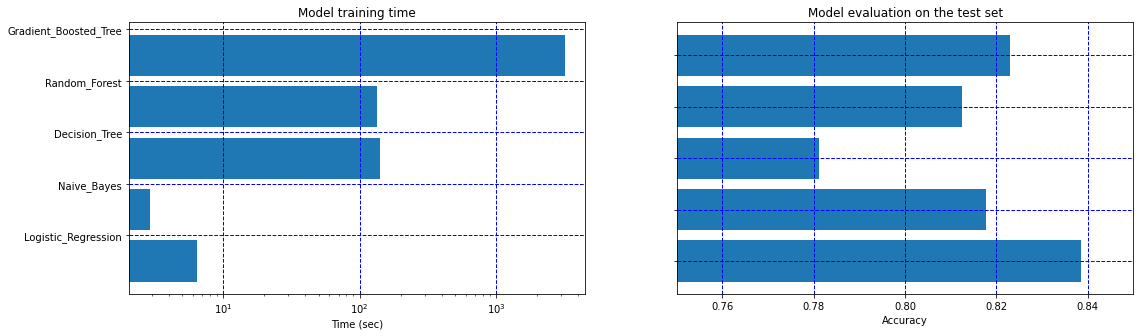

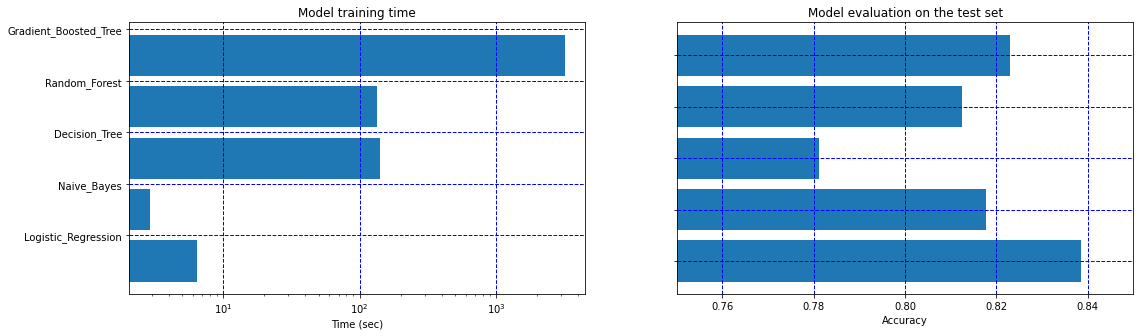

In [50]:
import matplotlib.pyplot as plt
import numpy as np
classifier_names=['Logistic_Regression', 'Naive_Bayes', 'Decision_Tree', 'Random_Forest', 'Gradient_Boosted_Tree']
time=[6.41,2.893,141,133,3179]
accuracy=[0.8385,0.8177,0.78125,0.8125,0.8229]
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5), facecolor='white')
ax[0].barh(np.arange(0, 5),time)
ax[0].set_yticks(np.arange(0.5, 5.5))
ax[0].set_yticklabels(classifier_names)
ax[0].grid(color='b', linestyle='--', linewidth=1)
ax[0].set_title('Model training time')
ax[0].set_xlabel('Time (sec)')
ax[0].set_xscale('log')

ax[1].barh(range(0, len(classifier_names)),accuracy)
ax[1].set_xlim([0.75,0.85])
ax[1].set_title('Model evaluation on the test set')
ax[1].set_xlabel('Accuracy')
ax[1].set_yticklabels([])
ax[1].grid(color='b', linestyle='--', linewidth=1)
display(fig)